# Throughput Analysis 

This notebook analyzes the throughput and model FLOP utilization (MFU) of sweeps across different dimensions such as sequence lengths and attention implementations. 
It visualizes the results in two plots: one for throughput and another for MFU.

A sweep is stored as a nested directory structure following the pattern:
`<timestamp_sweep_hash>/<num_ranks>/<config_hash_timestamp>`

Below is an example of this directory structure. At the top level, the runs are divided by the number of ranks used in the sweep.
Typically each rank folder contains the same experiments, the only difference is the number of ranks used.

We differentiate between successful runs, failed runs and runs that have not been executed yet.

* For a successful run, either the evaluation_result.jsonl file is present with the expected number of measurements (i.e., rows) or the error logs contain only expected errors (e.g., OOM).
* For a failed run, the error logs contain unexpected errors (e.g., IB timeout) or the evaluation_results.jsonl file is missing.
* For runs that have not been executed yet, the directory structure is present but no output files are generated.

Note that, sometimes an unexpected error might not be caught by the environment, in this case such a run is considered as not executed yet.

```txt
|-- 1024
|   |-- 12a3d358_2025-07-28__14-13-18                   # successful run
|   |   |-- evaluation_results.jsonl
|   |   |-- sweep_8B_fsdp2.yaml
|   |   `-- sweep_8B_fsdp2.yaml.resolved                                               
|   |-- 1046550d_2025-07-28__14-13-18                   # not run yet or failed with unexpected / non-caught error (e.g., IB timeout)
|   |   `-- sweep_8B_fsdp2.yaml
|   |-- 93a3f658_2025-07-28__14-13-18                   # failed run
|   |   `-- sweep_8B_fsdp2.yaml
|   |   |-- error_logs_lrdn0722.leonardo.local_0.log
|   |   `-- ...
|   |-- 93a3f658_2025-07-29__20-13-18                   # successful  rerun of failed run 93a3f658_2025-07-28__14-13-18
|   |   |-- evaluation_results.jsonl
|   |   |-- sweep_8B_fsdp2.yaml
|   |   `-- sweep_8B_fsdp2.yaml.resolved   
|   `-- ...
|-- 512                                               
|   |-- 93a3f658_2025-07-28__14-13-18                  
|   |   `-- sweep_8B_fsdp2.yaml
|   `-- ...
`-- ...                                               
```
When evaluating the throughput, we first filter only the most recent runs, i.e., for each config only the one with the most recent timestamp is considered.
In the example above, the run `93a3f658_2025-07-29__20-13-18` is considered for the throughput analysis instead of the run `93a3f658_2025-07-28__14-13-18`.

Each row in the `evaluation_results.jsonl` file contains the results of a single training step, including metrics such as loss, consumed tokens, gradient norms, and throughput metrics.

```json
{
  "dataloader_tag":"train",
  "num_train_steps_done":1,
  "losses":{
    "train loss avg":11.625,
    "train loss last":11.625
  },
  "metrics":{
    "consumed tokens":16384,
    "grad norm avg":42.65726852416992,
    "grad norm last":42.65726852416992
  },
  "throughput_metrics":{
    "train samples/s":2.747027635574341,
    "train mfu (16-bit)":0.1790606826543808,
    "lr mean":6.00299415509653e-07,
    "peak memory rank 0 (MB)":28988.275390625
  }
}
```

## Helper Scripts

In [1]:
from modalities.utils.benchmarking.benchmarking_utils import get_current_sweep_status, SweepSets, FileNames
from pathlib import Path
from collections import defaultdict
import json
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import reduce
import ipywidgets as widgets
from IPython.display import display

def get_num_ranks_from_config_path(config_path: Path) -> int:
    """Extracts the number of ranks from the config path."""
    return int(config_path.parent.parent.name)

def get_num_ranks_to_config_paths_dict(config_paths: list[Path]) -> dict[int, list[Path]]:
    rank_to_config = defaultdict(list)
    for config_path in config_paths:
        num_ranks = get_num_ranks_from_config_path(config_path)
        rank_to_config[num_ranks].append(config_path)
    return rank_to_config


def load_sweep(most_recent_configs: list[Path]) -> pd.DataFrame:
    rows = []

    for config_file_path in most_recent_configs:
        num_ranks = get_num_ranks_from_config_path(config_file_path)
        config_id = config_file_path.parent.name

        # load the most recent measurements if exists
        measurements_file_path = config_file_path.parent / FileNames.RESULTS_FILE.value

        # load config sweep
        with config_file_path.open("r") as f:
            yaml_config = yaml.safe_load(f)
        sweep_dict = yaml_config.get("sweep", {})
        
        # load measurements if exists
        measurements = []
        if measurements_file_path.exists():
            with measurements_file_path.open("r") as f:
                measurements = f.readlines()
            measurements = [json.loads(m) for m in measurements][-num_last_measurements:]
        
        
        throughput_dict = defaultdict(int)
        
        for m in measurements:
            throughput_dict["train samples/s"] += m["throughput_metrics"]["train samples/s"]
            throughput_dict["train mfu (16-bit)"] += m["throughput_metrics"]["train mfu (16-bit)"]
            throughput_dict["peak memory rank 0 (MB)"] += m["throughput_metrics"]["peak memory rank 0 (MB)"]

        # average the throughput metrics
        throughput_dict = {k: v / num_last_measurements for k, v in throughput_dict.items()}
        
        # load errors if exists
        errors_file_paths = config_file_path.parent.glob(FileNames.ERRORS_FILE_REGEX.value)
        errors = []
        for error_file_path in errors_file_paths:
            with error_file_path.open("r") as f:
                try:
                    error = json.load(f)
                    error_type = error["error"]["type"]
                except json.JSONDecodeError:
                    error_type = "ErrorFileParsingError"
                errors.append(error_type)
        errors = list(set(errors))  # unique error types

        row = {
            "config_id": config_id,
            "num_ranks": num_ranks,
            **sweep_dict,
            **throughput_dict,
            "errors": errors,
        }
        rows.append(row)
    df = pd.DataFrame(rows)
    return df

def get_sweep_config(experiments_folder: Path, yaml_file_name: str) -> dict[str, list]:
    sweep_files = list(experiments_folder.glob(f"**/{yaml_file_name}"))
    sweep = defaultdict(set)
    for sweep_file in sweep_files:
        yaml_config = yaml.safe_load(sweep_file.open("r"))
        for key, value in yaml_config.get("sweep", {}).items():
            sweep[key].add(value)
    sweep = {k: list(v) for k, v in sweep.items()}
    return sweep

##  Setup

In [2]:
# TODO: Update the path to your experiments folder
experiments_folder = Path("/leonardo_scratch/fast/EUHPC_D21_101/max_lue/repositories/working/modalities/tutorials/scaling_up/experiments/2025-09-25__16-30-29_9a5c69962be24784")
yaml_file_name = "sweep_8B_fsdp2.yaml"
expected_steps = 20
skip_exception_types = ["OutOfMemoryError"]

num_last_measurements = 3

## Loading results

First, we collect all the configs from the sweep and filter them as follows. 
`all_configs` contains all the configs that have been or still have to be run. `most_recent_configs` contains a subset of configs that have been run most recently (i.e., those that contain the most recent results or most recently failed).
`remaining_configs` is a subset of `most_recent_configs` for which we don't have any results yet or which have failed unexpectedly.

In [3]:
experiments_dict = get_current_sweep_status(exp_root=experiments_folder, expected_steps=expected_steps, skip_exception_types=skip_exception_types)
{k: len(v) for k,v in experiments_dict.items()}

main - WARNING - Failed to parse error log /leonardo_scratch/fast/EUHPC_D21_101/max_lue/repositories/working/modalities/tutorials/scaling_up/experiments/2025-09-25__16-30-29_9a5c69962be24784/128/360bcff400e8b881_2025-09-25__16-30-29/error_logs_lrdn1199.leonardo.local_0.log: Expecting value: line 1 column 1 (char 0)
main - WARNING - Failed to parse error log /leonardo_scratch/fast/EUHPC_D21_101/max_lue/repositories/working/modalities/tutorials/scaling_up/experiments/2025-09-25__16-30-29_9a5c69962be24784/128/360bcff400e8b881_2025-09-25__16-30-29/error_logs_lrdn0827.leonardo.local_0.log: Expecting value: line 1 column 1 (char 0)


{'all_configs': 97, 'most_recent_configs': 48, 'remaining_configs': 1}

In [4]:
sweep_config = get_sweep_config(experiments_folder, yaml_file_name)
sweep_keys = set(sweep_config.keys())
sweep_config

{'local_train_micro_batch_size': [1, 2, 3, 4],
 'sequence_length': [4096, 2048],
 'attention_implementation': ['pytorch_flash'],
 'fsdp2_input_model': ['model_raw'],
 'num_target_steps': [20]}

In [5]:
all_configs = experiments_dict[SweepSets.ALL_CONFIGS.value]
most_recent_configs = experiments_dict[SweepSets.MOST_RECENT_CONFIGS.value]
remaining_configs = experiments_dict[SweepSets.REMAINING_CONFIGS.value]
print(f"All configs: {len(all_configs)}")
print(f"Most recent configs: {len(most_recent_configs)}")
print(f"Remaining configs: {len(remaining_configs)}")

All configs: 97
Most recent configs: 48
Remaining configs: 1


In [6]:
num_ranks_to_remaining_configs = get_num_ranks_to_config_paths_dict(remaining_configs)

print("Remaining configs by number of ranks:")
for num_ranks, configs in num_ranks_to_remaining_configs.items():
    print(f"Number of ranks: {num_ranks}, Remaining configs: {len(configs)}")

Remaining configs by number of ranks:
Number of ranks: 64, Remaining configs: 1


## Results Analysis

In [7]:
df = load_sweep(most_recent_configs)
df

,config_id,num_ranks,local_train_micro_batch_size,sequence_length,attention_implementation,fsdp2_input_model,num_target_steps,errors,train samples/s,train mfu (16-bit),peak memory rank 0 (MB)
0,ab20d574dbd6982d_2025-09-25__16-30-29,16,3,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
1,a1bc5fd811f3ce33_2025-09-25__16-30-29,16,2,2048,pytorch_flash,model_raw,20,[],35.153543,0.572857,27184.261719
2,c52825fc00a231ee_2025-09-25__16-30-29,16,4,2048,pytorch_flash,model_raw,20,[],41.080528,0.669442,48957.261719
3,ef6eaec8fc116be8_2025-09-25__16-30-29,16,1,4096,pytorch_flash,model_raw,20,[],16.749470,0.590164,27216.261719
4,ebde23703bc62c2e_2025-09-25__16-30-29,16,3,2048,pytorch_flash,model_raw,20,[],39.028812,0.636008,38151.738281
5,2dc0f4c0d181e3be_2025-09-25__16-30-29,16,1,2048,pytorch_flash,model_raw,20,[],21.300732,0.347114,16937.007812
6,f11f146527a4387b_2025-09-25__16-30-29,16,2,4096,pytorch_flash,model_raw,20,[],19.514189,0.687578,48989.261719
7,360bcff400e8b881_2025-09-25__16-30-29,16,4,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
8,ab20d574dbd6982d_2025-09-25__16-30-29,8,3,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
9,a1bc5fd811f3ce33_2025-09-25__16-30-29,8,2,2048,pytorch_flash,model_raw,20,[],17.672795,0.575987,31643.144531


### All results for a given sequence length

In [8]:
sequence_length = 4096
df_seq = df[df["sequence_length"] == sequence_length]

with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.max_colwidth', None,
    'display.expand_frame_repr', False
):
    display(df_seq.sort_values(by=["num_ranks", "local_train_micro_batch_size", "train samples/s"], ascending=True))

,config_id,num_ranks,local_train_micro_batch_size,sequence_length,attention_implementation,fsdp2_input_model,num_target_steps,errors,train samples/s,train mfu (16-bit),peak memory rank 0 (MB)
27,ef6eaec8fc116be8_2025-09-25__16-30-29,4,1,4096,pytorch_flash,model_raw,20,[],4.338593,0.611477,40365.906250
30,f11f146527a4387b_2025-09-25__16-30-29,4,2,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],0.767793,0.108212,16837.920573
24,ab20d574dbd6982d_2025-09-25__16-30-29,4,3,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
31,360bcff400e8b881_2025-09-25__16-30-29,4,4,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
11,ef6eaec8fc116be8_2025-09-25__16-30-29,8,1,4096,pytorch_flash,model_raw,20,[],8.490028,0.598288,31675.144531
14,f11f146527a4387b_2025-09-25__16-30-29,8,2,4096,pytorch_flash,model_raw,20,[],9.810673,0.691354,53433.144531
8,ab20d574dbd6982d_2025-09-25__16-30-29,8,3,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
15,360bcff400e8b881_2025-09-25__16-30-29,8,4,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
3,ef6eaec8fc116be8_2025-09-25__16-30-29,16,1,4096,pytorch_flash,model_raw,20,[],16.749470,0.590164,27216.261719
6,f11f146527a4387b_2025-09-25__16-30-29,16,2,4096,pytorch_flash,model_raw,20,[],19.514189,0.687578,48989.261719


### Missing results
i.e., those that have not been run yet or failed unexpectedly (i.e., no error was captured). 


In [9]:
df_remaining = df[
    (df["errors"].apply(lambda x: len(x) == 0)) &
    (df["train samples/s"].isna())
]

with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.max_colwidth', None,
    'display.expand_frame_repr', False
):
    display(df_remaining)

,config_id,num_ranks,local_train_micro_batch_size,sequence_length,attention_implementation,fsdp2_input_model,num_target_steps,errors,train samples/s,train mfu (16-bit),peak memory rank 0 (MB)
17,ef6eaec8fc116be8_2025-09-25__21-10-05,64,1,4096,pytorch_flash,model_raw,20,[],NaN,NaN,NaN


### Failed jobs
i.e., those that have been run but failed with an exception


In [10]:
df_remaining = df[
    (df["errors"].apply(lambda x: len(x) > 0)) &
    (df["train samples/s"].isna())
]

with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.max_colwidth', None,
    'display.expand_frame_repr', False
):
    display(df_remaining)

,config_id,num_ranks,local_train_micro_batch_size,sequence_length,attention_implementation,fsdp2_input_model,num_target_steps,errors,train samples/s,train mfu (16-bit),peak memory rank 0 (MB)
0,ab20d574dbd6982d_2025-09-25__16-30-29,16,3,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
7,360bcff400e8b881_2025-09-25__16-30-29,16,4,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
8,ab20d574dbd6982d_2025-09-25__16-30-29,8,3,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
15,360bcff400e8b881_2025-09-25__16-30-29,8,4,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
18,ab20d574dbd6982d_2025-09-25__18-44-14,64,3,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
21,360bcff400e8b881_2025-09-25__18-44-14,64,4,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
24,ab20d574dbd6982d_2025-09-25__16-30-29,4,3,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
31,360bcff400e8b881_2025-09-25__16-30-29,4,4,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
32,ab20d574dbd6982d_2025-09-25__18-27-50,32,3,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN
39,360bcff400e8b881_2025-09-25__18-27-50,32,4,4096,pytorch_flash,model_raw,20,[OutOfMemoryError],NaN,NaN,NaN


In [11]:
error_types = list(set(df_remaining["errors"].explode()))
error_types

['ErrorFileParsingError', 'OutOfMemoryError']

### Throughput Analysis

In [ ]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class UISelection:
    group_keys: Optional[list] = None

ui_selection = UISelection()


explanation = widgets.HTML(
    value="<b>Select the sweep configurations you want to filter:</b><br>"
          "You can tick multiple options - each one corresponds to a different hyperparameter. The remaining hyperparameters will be aggregated over by selecting the max <b>throughput </b> value."
)

# Create checkboxes
checkboxes = [
    widgets.Checkbox(
        value=False,
        description=f"{opt}: {sweep_config[opt]}",
        layout=widgets.Layout(width="800px")
    )
    for opt in sweep_config
]
ui = widgets.VBox([explanation] + checkboxes)
display(ui)

def get_selected_ids():
    return [i for i, cb in enumerate(checkboxes) if cb.value]

# Example button
button = widgets.Button(description="Apply selection")
output = widgets.Output()

def on_click(b):
    with output:
        output.clear_output()
        options = list(sweep_config.keys())
        group_keys = [options[i] for i in get_selected_ids()]
        print("Selected:", group_keys)
        ui_selection.group_keys = group_keys


group_keys = button.on_click(on_click)
display(button, output)



Button(description='Apply selection', style=ButtonStyle())

Output()

In [14]:
group_keys = ui_selection.group_keys
aggregation_dims_set = set(sweep_config.keys()).difference(set(group_keys))
considered_dims = group_keys

print(f"Aggregation dims: {list(aggregation_dims_set)}")
print(f"Considered dims: {considered_dims}")

Aggregation dims: ['fsdp2_input_model', 'num_target_steps', 'attention_implementation']
Considered dims: ['local_train_micro_batch_size', 'sequence_length']


In [15]:
df_filtered = df[
    (df["errors"].apply(lambda x: len(x) == 0)) &
    (~df["train samples/s"].isna())
]

best_rows = (
    df_filtered
    .sort_values("train samples/s", ascending=False)
    .drop_duplicates(subset=group_keys + ["num_ranks"])
)

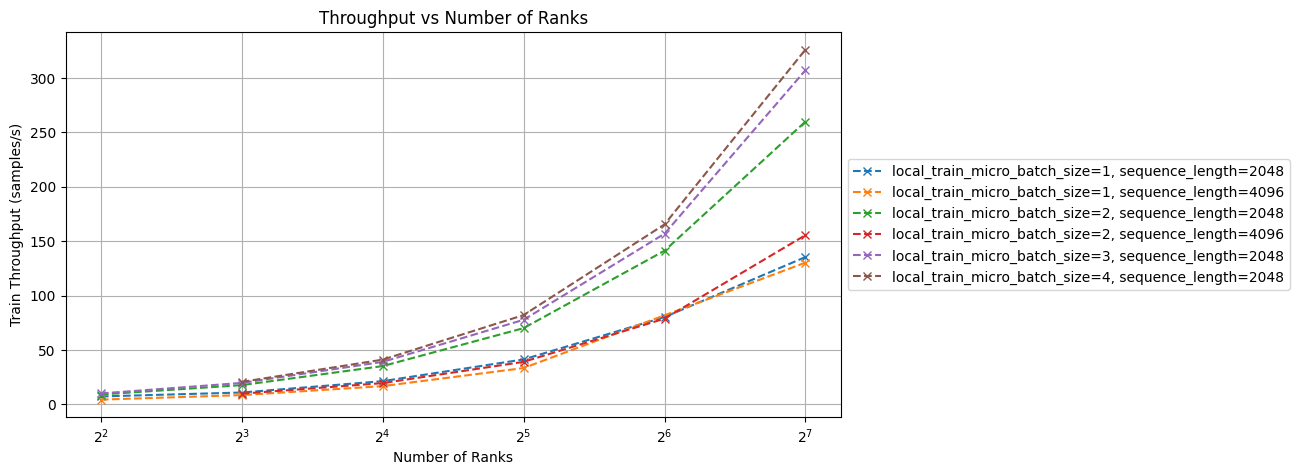

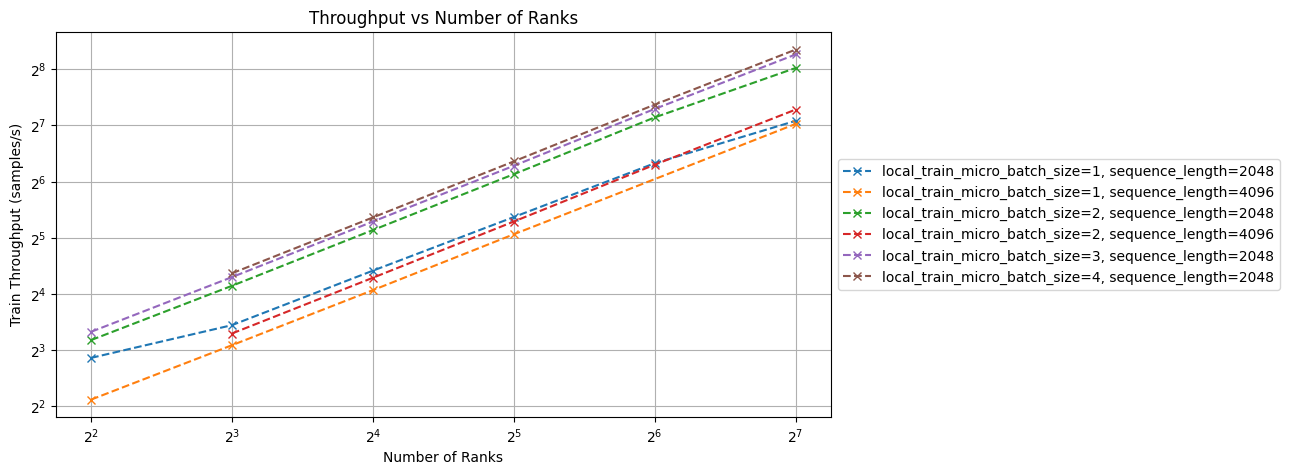

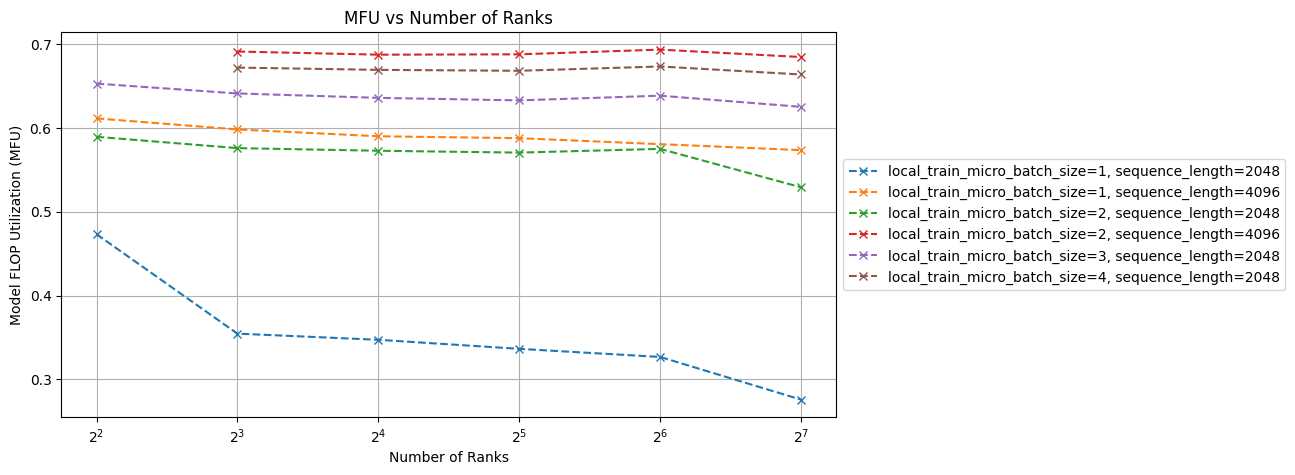

In [16]:
assert set(group_keys).issubset(sweep_keys), f"Group keys {group_keys} not all in sweep keys {sweep_keys}"

# --- Plot 1: Throughput ---
fig1, ax1 = plt.subplots(figsize=(10, 5))

for val_tuple, group in best_rows.groupby(group_keys):
    label_dict = {key: val for key, val in zip(group_keys, val_tuple)}
    group = group.sort_values("num_ranks")
    label = ", ".join([f"{k}={v}" for k, v in label_dict.items()])
    ax1.plot(group["num_ranks"], group["train samples/s"], marker='x', linestyle='--', label=label)

ax1.set_title("Throughput vs Number of Ranks")
ax1.set_xlabel("Number of Ranks")
ax1.set_ylabel("Train Throughput (samples/s)")
ax1.set_xscale("log", base=2)  # ← logarithmic x-axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.grid(True, which="both")

# --- Plot 1: Throughput ---
fig1, ax1 = plt.subplots(figsize=(10, 5))

for val_tuple, group in best_rows.groupby(group_keys):
    label_dict = {key: val for key, val in zip(group_keys, val_tuple)}
    group = group.sort_values("num_ranks")
    label = ", ".join([f"{k}={v}" for k, v in label_dict.items()])
    ax1.plot(group["num_ranks"], group["train samples/s"], marker='x', linestyle='--', label=label)

ax1.set_title("Throughput vs Number of Ranks")
ax1.set_xlabel("Number of Ranks")
ax1.set_ylabel("Train Throughput (samples/s)")
ax1.set_xscale("log", base=2)  # ← logarithmic x-axis
ax1.set_yscale("log", base=2)  # ← logarithmic x-axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.grid(True, which="both")

# --- Plot 2: MFU ---
fig2, ax2 = plt.subplots(figsize=(10, 5))

for val_tuple, group in best_rows.groupby(group_keys):
    label_dict = {key: val for key, val in zip(group_keys, val_tuple)}
    group = group.sort_values("num_ranks")
    label = ", ".join([f"{k}={v}" for k, v in label_dict.items()])
    ax2.plot(group["num_ranks"], group["train mfu (16-bit)"], marker='x', linestyle='--', label=label)

ax2.set_title("MFU vs Number of Ranks")
ax2.set_xlabel("Number of Ranks")
ax2.set_ylabel("Model FLOP Utilization (MFU)")
ax2.set_xscale("log", base=2)  # ← logarithmic x-axis
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid(True, which="both")

plt.show()

## Memory footprint analysis

As the memory pressure increases, the throughput can plummet. To investigate this, we can plot the peak memory usage per rank against the throughput and highlight the best configurations.

In [ ]:
from dataclasses import dataclass
from typing import Optional
import ipywidgets as widgets
from IPython.display import display

@dataclass
class UISelection:
    selected: Optional[dict] = None  # key -> list of selected values

ui_selection = UISelection()

explanation = widgets.HTML(
    value="<b>Select the specific hyperparameter values you want to filter:</b><br>"
          "Each row corresponds to one hyperparameter. You can tick multiple values per row.<br>"
          "The non-ticked values of a ticked row will be disregarded from the analysis"
)

rows = []         # list of HBox rows
checkbox_mapping = {}  # key -> list of (value, checkbox)

for key, values in sweep_config.items():
    vals = values if isinstance(values, (list, tuple)) else [values]
    checkboxes = []
    for v in vals:
        cb = widgets.Checkbox(
            value=False,
            description=str(v),
            indent=False  # keeps checkboxes compact
        )
        checkboxes.append((v, cb))
    checkbox_mapping[key] = checkboxes
    
    # Row: Label on the left + checkboxes horizontally
    row_label = widgets.Label(value=f"{key}:", layout=widgets.Layout(width="300px"))
    row_box = widgets.HBox([row_label] + [cb for _, cb in checkboxes])
    rows.append(row_box)

# Combine everything into a single VBox
ui = widgets.VBox([explanation] + rows)
display(ui)

# Helper: gather selections into dict
def get_selected_dict():
    selected = {}
    for key, pairs in checkbox_mapping.items():
        sel = [v for v, cb in pairs if cb.value]
        if sel:  # only include if something was chosen
            selected[key] = sel
    return selected

# Button + output
button = widgets.Button(description="Apply selection")
output = widgets.Output()

def on_click(b):
    with output:
        output.clear_output()
        selections = get_selected_dict()
        print("Selected values:")
        for k, vs in selections.items():
            print(f" - {k}: {vs}")
        ui_selection.selected = selections

button.on_click(on_click)
display(button, output)


Button(description='Apply selection', style=ButtonStyle())

Output()

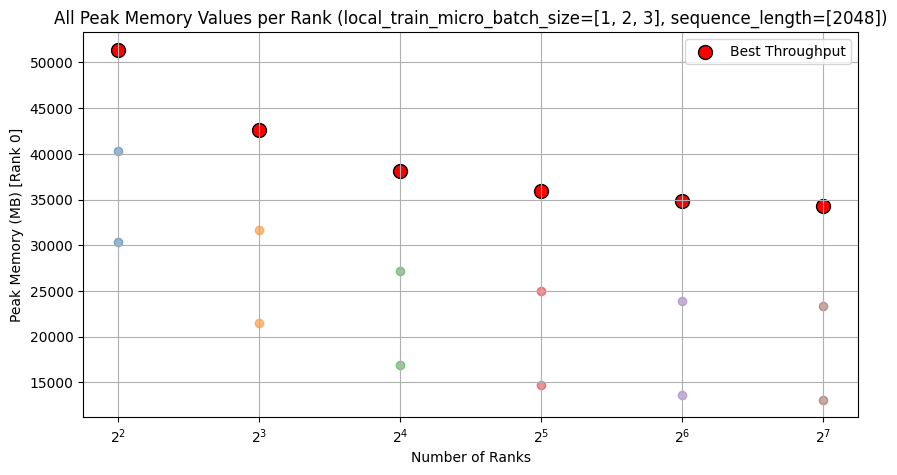

In [18]:
filter_dict = ui_selection.selected
mask = True
if len(filter_dict) > 0:
    mask = reduce(lambda x, y: x & y, [df_filtered[key].isin(value) for key, value in filter_dict.items()])

df_valid = df_filtered[df_filtered["train samples/s"].notnull() & mask]

# Best row per num_ranks
best_rows = (
    df_valid
    .sort_values("train samples/s", ascending=False)
    .drop_duplicates(subset=["num_ranks"])
)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot all memory values as background points
for num_ranks, group in df_valid.groupby("num_ranks"):
    ax.scatter(
        [num_ranks] * len(group),
        group["peak memory rank 0 (MB)"],
        alpha=0.5,
        label=f"{num_ranks} ranks" if num_ranks not in best_rows["num_ranks"].values else None
    )

# Plot best ones as red dots with black edge
ax.scatter(
    best_rows["num_ranks"],
    best_rows["peak memory rank 0 (MB)"],
    color="red",
    edgecolors="black",
    s=100,
    label="Best Throughput"
)

# Final touches
ax.set_title(f"All Peak Memory Values per Rank ({', '.join([f'{k}={v}' for k, v in filter_dict.items()])})")
ax.set_xlabel("Number of Ranks")
ax.set_ylabel("Peak Memory (MB) [Rank 0]")
ax.set_xscale("log", base=2)
ax.grid(True, which="both")
ax.legend()
plt.show()